In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import re

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

In [5]:

drinks_df = pd.read_csv("cocktail-data/drinks.csv")

In [6]:
drinks_df.head()

Cocktail Name          Bartender      Bar/Company  \
0             Flor de Amaras     Kelly McCarthy              NaN   
1            The Happy Place  Elizabeth Montana  Forgery & Verso   
2     Bon Voyage Pisco Punch        Jon Morales              NaN   
3  Still Life of a Pineapple    Daniel Braganca          Backbar   
4        The Bittered Valley         Nik Virrey              NaN   

        Location                                        Ingredients  \
0         Boston  1.5 oz Mezcal, 1 oz Hibiscus Simple Syrup*, .5...   
1  San Francisco  2 oz Junipero Gin, .75 oz House-made Cranberry...   
2  San Francisco  1500 ml BarSol Selecto Italia Pisco, 750 ml Le...   
3     Somerville  1.5 oz BarSol Primero Quebranta Pisco, .75 oz ...   
4        Seattle  1.25 oz Luxardo Maraschino Liqueur, 4 drops Ac...   

                                     Garnish   Glassware  \
0                            Marigold Petals         NaN   
1  Dehydrated Lemon Wheel, Sprig of Rosemary         NaN   
2                                        NaN  Punch Bowl   
3                                        NaN         NaN   
4                                        NaN         NaN   

                                         Preparation  \
0  *Hibiscus Simple Syrup:\n1:1 w/ a cup of dried...   
1  *House-made Cranberry syrup: \n-- 2 cups Fresh...   
2  *Pineapple Gomme: \nMix equal parts (1.5 cups)...   
3  *Pineapple Syrup:\n<em>Equal parts pineapple b...   
4  1st glass ingredients:\nLuxardo Maraschino, Ac...   

                                              Notes  
0                                               NaN  
1  Junipero Gin 20th Anniversary Signature Cocktail  
2                                               NaN  
3                                               NaN  
4                                               NaN

In [15]:
print(drinks_df.shape)
print(drinks_df.isnull().sum())


(687, 9)
Cocktail Name      0
Bartender        235
Bar/Company      417
Location         345
Ingredients        0
Garnish          164
Glassware        202
Preparation       45
Notes            536
dtype: int64


In [16]:
print(drinks_df.describe())

       Cocktail Name             Bartender  Bar/Company       Location  \
count            687                   452          270            342   
unique           684                   250          168             41   
top      Rita's Song  Francesco Lafranconi  Dirty Habit  San Francisco   
freq               2                    38           29            156   

                                              Ingredients         Garnish  \
count                                                 687             523   
unique                                                686             318   
top     1 oz No.3 London Dry Gin, 1 oz Tempus Fugit Al...  Luxardo Cherry   
freq                                                    2              32   

       Glassware                                        Preparation  \
count        485                                                642   
unique        66                                                630   
top        Coupe  Shake until 

In [44]:
# Split ingredients by comma and count the number of ingredients (excluding measurements and units)
def count_ingredients(ingredients):
    ingredient_list = [re.sub(r'\d+\s*oz\s*', '', ingredient).strip() for ingredient in ingredients.split(',')]
    return len(ingredient_list)

drinks_df['Ingredient Count'] = drinks_df['Ingredients'].apply(count_ingredients)

# Find the most common ingredients (excluding measurements and units)
ingredients_list = [re.sub(r'\d+(\.\d+)?\s*oz\s*', '', ingredient).strip() for ingredients in drinks_df['Ingredients'] for ingredient in ingredients.split(',')]
common_ingredients = pd.Series(ingredients_list).value_counts()

print("Ingredient Count Statistics:")
print(drinks_df['Ingredient Count'].describe())

print("\nTop 10 Common Ingredients:")
print(common_ingredients.head(10))


Ingredient Count Statistics:
count    687.000000
mean       4.707424
std        1.409150
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max       13.000000
Name: Ingredient Count, dtype: float64

Top 10 Common Ingredients:
.Lemon Juice                   76
.Luxardo Maraschino Liqueur    65
No.3 London Dry Gin            63
Junipero Gin                   62
.King's Ginger Liqueur         42
.Lime Juice                    38
H by HINE                      38
King's Ginger Liqueur          36
.Fresh Lemon Juice             32
Pink Pigeon Rum                29
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (785404, 3)
Shape of test data: (196352, 3)


## CREATE A NEURAL NETWORK

In [7]:
#Get the number of unique entities in books and users columns
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()


#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)

model = tf.Model([input_books, input_users], x_out)

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')

TypeError: Unexpected keyword argument passed to optimizer: learning_rate

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Train on 785404 samples, validate on 196352 samples
Epoch 1/5
785404/785404 [==============================] - 224s 285us/sample - loss: 0.8675 - val_loss: 0.7156
Epoch 2/5
785404/785404 [==============================] - 229s 292us/sample - loss: 0.6845 - val_loss: 0.6970
Epoch 3/5
785404/785404 [==============================] - 228s 291us/sample - loss: 0.6489 - val_loss: 0.6960
Epoch 4/5
785404/785404 [==============================] - 231s 294us/sample - loss: 0.6188 - val_loss: 0.7017
Epoch 5/5
785404/785404 [==============================] - 231s 295us/sample - loss: 0.5901 - val_loss: 0.7124


In [ ]:
hist.history

{'loss': [0.8674743072231863,
  0.6845383935480744,
  0.6488857544590257,
  0.6188146994932093,
  0.5900726376406444],
 'val_loss': [0.7155714221347265,
  0.6970150542810968,
  0.6960220991632619,
  0.7016856827939505,
  0.7123982415011219]}

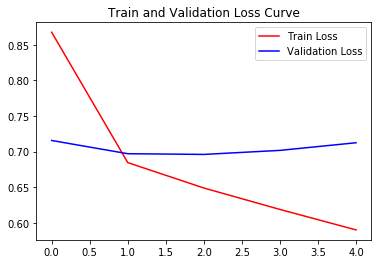

In [ ]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.savefig("loss.png")
plt.show()

In [ ]:
#save the model
model.save('model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [ ]:
# tf.utils.plot_model(model)

## EXTRACT EMBEDDING LAYERS AND MAPPING FOR VISUALIZATION IN TENSORFLOW EMBEDDING PROJECTOR

In [ ]:
# Extract embeddings
book_em = model.get_layer('embedding')
book_em_weights = book_em.get_weights()[0]

In [ ]:
book_em_weights.shape

(10001, 15)

In [ ]:
books_df_copy = books_df.copy()
books_df_copy = books_df_copy.set_index("book_id")
books_df_copy.head(2)

id  best_book_id  work_id  books_count       isbn        isbn13  \
book_id                                                                    
2767052   1       2767052  2792775          272  439023483  9.780439e+12   
3         2             3  4640799          491  439554934  9.780440e+12   

                             authors  original_publication_year  \
book_id                                                           
2767052              Suzanne Collins                     2008.0   
3        J.K. Rowling, Mary GrandPré                     1997.0   

                                   original_title  \
book_id                                             
2767052                          The Hunger Games   
3        Harry Potter and the Philosopher's Stone   

                                                     title  ... ratings_count  \
book_id                                                     ...                 
2767052            The Hunger Games (The Hunger Games, #1)  ...       4780653   
3        Harry Potter and the Sorcerer's Stone (Harry P...  ...       4602479   

         work_ratings_count  work_text_reviews_count  ratings_1  ratings_2  \
book_id                                                                      
2767052             4942365                   155254      66715     127936   
3                   4800065                    75867      75504     101676   

         ratings_3  ratings_4  ratings_5  \
book_id                                    
2767052     560092    1481305    2706317   
3           455024    1156318    3011543   

                                                 image_url  \
book_id                                                      
2767052  https://images.gr-assets.com/books/1447303603m...   
3        https://images.gr-assets.com/books/1474154022m...   

                                           small_image_url  
book_id                                                     
2767052  https://images.gr-assets.com/books/1447303603s...  
3        https://images.gr-assets.com/books/1474154022s...  

[2 rows x 22 columns]

In [ ]:
b_id =list(ratings_df.book_id.unique())
b_id.remove(10000)

In [ ]:
dict_map = {}
for i in b_id:
    dict_map[i] = books_df_copy.iloc[i]['title']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')

for i in b_id:
    book = dict_map[i]
    embeddings = book_em_weights[i]
    out_m.write(book + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

## MAKING PREDICTIONS

In [ ]:
book_arr = np.array(b_id)
user = np.array([53424 for i in range(len(b_id))])
pred = model.predict([book_arr, user])

In [ ]:
pred

array([[4.5011272],
       [4.3990316],
       [3.519008 ],
       ...,
       [4.4370375],
       [4.5189867],
       [3.6977477]], dtype=float32)

In [ ]:
pred = pred.reshape(-1)
pred_ids = (-pred).argsort()[0:5]
pred_ids

array([7946, 1787, 9568, 4777, 8975])

In [ ]:
ratings_df.user_id.nunique()

53424

In [ ]:
books_df.iloc[pred_ids]

id   book_id  best_book_id   work_id  books_count        isbn  \
7946  7947   5031805       5031805  40769318           96  1433502410   
1787  1788     24813         24813    692719           17   836204387   
9568  9569  32075671      32075671  49638190           36    62498533   
4777  4778   5883777       5883777  21899016          627         NaN   
8975  8976     39664         39664  24951203           37   896214400   

            isbn13                                     authors  \
7946  9.781434e+12  Anonymous, Lane T. Dennis, Wayne A. Grudem   
1787  9.780836e+12                              Bill Watterson   
9568  9.780062e+12                                Angie Thomas   
4777           NaN                                   Anonymous   
8975  9.780896e+12                                Stephen King   

      original_publication_year                                original_title  \
7946                     2002.0                                           NaN   
1787                     1995.0  The Calvin and Hobbes Tenth Anniversary Book   
9568                     2017.0                               The Hate U Give   
4777                     2001.0           Holy Bible English Standard Version   
8975                     1982.0                      The Shawshank Redemption   

      ... ratings_count work_ratings_count  work_text_reviews_count  \
7946  ...          8953              10784                      262   
1787  ...         48280              48829                      346   
9568  ...         32610              38333                     9038   
4777  ...         17863              23236                      591   
8975  ...         11499              12882                      788   

      ratings_1  ratings_2  ratings_3  ratings_4  ratings_5  \
7946         98         90        367       1152       9077   
1787        346        608       3077       8752      36046   
9568        208        321       1814       9207      26783   
4777        652        431       1082       1909      19162   
8975         16        115       1003       3776       7972   

                                              image_url  \
7946  https://images.gr-assets.com/books/1410151002m...   
1787  https://s.gr-assets.com/assets/nophoto/book/11...   
9568  https://images.gr-assets.com/books/1476284759m...   
4777  https://images.gr-assets.com/books/1328227151m...   
8975  https://images.gr-assets.com/books/1315100686m...   

                                        small_image_url  
7946  https://images.gr-assets.com/books/1410151002s...  
1787  https://s.gr-assets.com/assets/nophoto/book/50...  
9568  https://images.gr-assets.com/books/1476284759s...  
4777  https://images.gr-assets.com/books/1328227151s...  
8975  https://images.gr-assets.com/books/1315100686s...  

[5 rows x 23 columns]

### Prepare Data for use on application

In [ ]:
web_book_data = books_df[["book_id", "title", "image_url", "authors"]]
web_book_data = web_book_data.sort_values('book_id')

In [ ]:
web_book_data.head()

book_id                                              title  \
26        1  Harry Potter and the Half-Blood Prince (Harry ...   
20        2  Harry Potter and the Order of the Phoenix (Har...   
1         3  Harry Potter and the Sorcerer's Stone (Harry P...   
17        5  Harry Potter and the Prisoner of Azkaban (Harr...   
23        6  Harry Potter and the Goblet of Fire (Harry Pot...   

                                            image_url  \
26  https://images.gr-assets.com/books/1361039191m...   
20  https://images.gr-assets.com/books/1387141547m...   
1   https://images.gr-assets.com/books/1474154022m...   
17  https://images.gr-assets.com/books/1499277281m...   
23  https://images.gr-assets.com/books/1361482611m...   

                                    authors  
26              J.K. Rowling, Mary GrandPré  
20              J.K. Rowling, Mary GrandPré  
1               J.K. Rowling, Mary GrandPré  
17  J.K. Rowling, Mary GrandPré, Rufus Beck  
23              J.K. Rowling, Mary GrandPré

In [ ]:
web_book_data.to_json(r'web_book_data.json', orient='records')